In [1]:
#pip install mne
import mne
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import signal
from matplotlib.pyplot import figure


Считаем данные в формате edf

In [2]:
file = "Data VECG\PatientA__Exam_1_0.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\PatientA__Exam_1_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
channels

['ECG I', 'ECG II', 'ECG V1', 'ECG V2', 'ECG V3', 'ECG V4', 'ECG V5', 'ECG V6']

In [4]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG I, ECG II, ECG V1, ECG V2, ECG V3, ECG V4, ECG V5, ECG V6
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2011-08-09 00:00:00 UTC
 nchan: 8
 projs: []
 sfreq: 500.0 Hz
>

In [5]:
fd = 500 # Частота дискретизации
raw_data.shape

(8, 5000)

In [6]:
df = pd.DataFrame(data=raw_data.T,    # values
...              index=range(raw_data.shape[1]),    # 1st column as index
...              columns=channels)  # 1st row as the column names
df

,ECG I,ECG II,ECG V1,ECG V2,ECG V3,ECG V4,ECG V5,ECG V6
0,-0.000163,0.000236,-0.000398,-0.000547,-0.000354,-0.000382,-0.000423,-0.000447
1,-0.000157,0.000240,-0.000397,-0.000548,-0.000354,-0.000383,-0.000425,-0.000449
2,-0.000157,0.000240,-0.000397,-0.000549,-0.000355,-0.000383,-0.000424,-0.000446
3,-0.000165,0.000238,-0.000399,-0.000549,-0.000357,-0.000383,-0.000423,-0.000441
4,-0.000167,0.000239,-0.000402,-0.000548,-0.000356,-0.000384,-0.000422,-0.000440
...,...,...,...,...,...,...,...,...
4995,-0.000185,0.000182,0.000005,-0.000557,-0.000245,-0.000043,-0.000370,-0.000295
4996,-0.000184,0.000184,0.000004,-0.000554,-0.000243,-0.000042,-0.000369,-0.000295
4997,-0.000182,0.000185,0.000002,-0.000554,-0.000243,-0.000041,-0.000368,-0.000295
4998,-0.000182,0.000184,0.000003,-0.000554,-0.000245,-0.000042,-0.000368,-0.000296


In [7]:
Ts = 1/fd
t = []
for i in range(raw_data.shape[1]):
    t.append(i*Ts)
max(t)

9.998

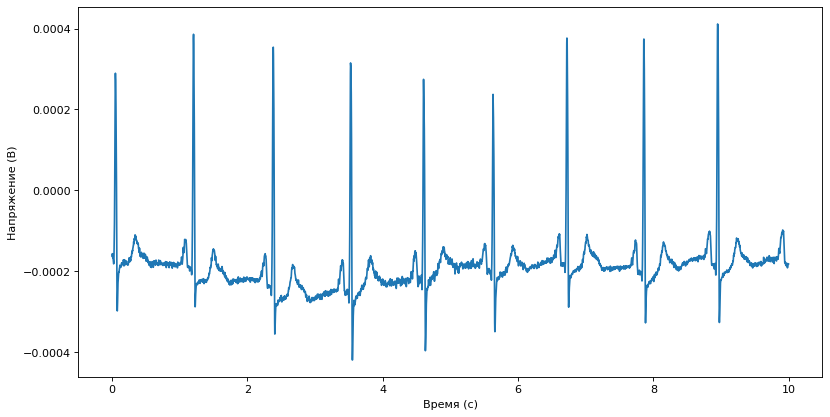

In [8]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(t, df['ECG I'])
plt.xlabel('Время (с)')
plt.ylabel('Напряжение (В)')
plt.show()

In [9]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()      # parameters not required.
model.load_model('boosting_model_ECG.cbm');

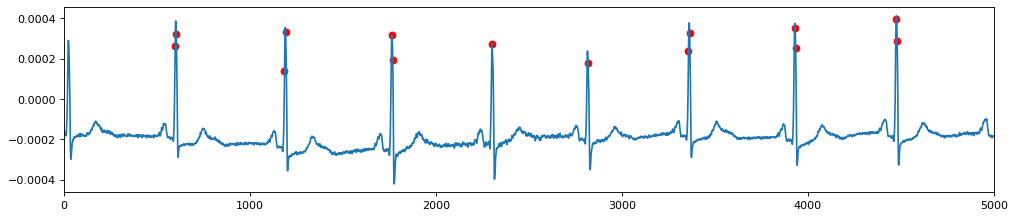

In [11]:
sig = np.array(df['ECG I'])
window = 200
dataset_check = []
middles = []
for i in range(0, len(sig)-window, 6):
    piece = sig[i:i+window] / np.max(np.abs(sig[i:i+window]))
    piece = piece - np.mean(piece)
    middle = (i + i + window) / 2
    middles.append(middle)
    dataset_check.append(piece)
df_check = pd.DataFrame(dataset_check)
test_preds = model.predict(df_check, prediction_type="Class")
peaks = np.where(test_preds>0)[0]

# Сделаем временный сигнал, который всегда имеет min значение = 0
temp_sig = sig
if min(sig) < 0:
    temp_sig = sig + abs(min(sig))
if min(sig) > 0:
    temp_sig = sig - abs(min(sig))

h = max(temp_sig)/1.5  # Выберем только те пики, которые >
true_peaks = []

for i in peaks:
    m = int(middles[i])
    if temp_sig[m]>h:
        true_peaks.append(i)


middles = np.asarray(middles)
figure(figsize=(15, 3), dpi=80)
plt.plot(sig)
plt.scatter(middles[true_peaks], [list(sig)[x] for x in list((middles[true_peaks]).astype(np.int64))], color='red')
plt.xlim([0, 5000]);

Сделаем так, чтобы один кардиоцикл имел ровно 1 задетектированный пик. 
Условие будет такое: если между соседними пиками расстояние меньше чем 0.2 мс, тогда оставить надо как значение пика - среднее значение между точками

In [12]:
coordinates = middles[true_peaks].astype(np.int64)
coordinates = np.concatenate((coordinates, max(coordinates)+10000),axis=None)
final_coord = []
val_last = 0
data_points = []
for val in coordinates:
    if val - val_last > (0.2/Ts):
        if len(data_points)!=0:
            final_coord.append(int(np.array(data_points).mean()))
            data_points = []
    data_points.append(val)
    val_last = val

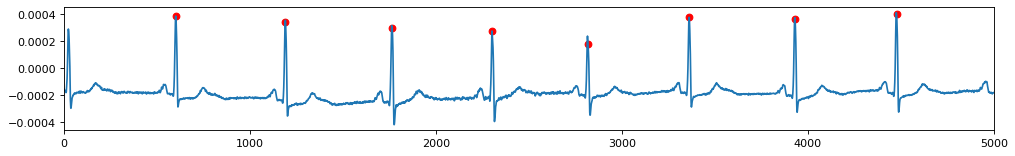

In [13]:
figure(figsize=(15, 2), dpi=80)
plt.plot(sig)
plt.scatter(final_coord, sig[final_coord], color='red')
plt.xlim([0, 5000]);

Так как все сигналы записаны отновременно со всех отведений, поэтому эти же найденные координаты на 1 отведении можно перенести с легкостью на все остальные

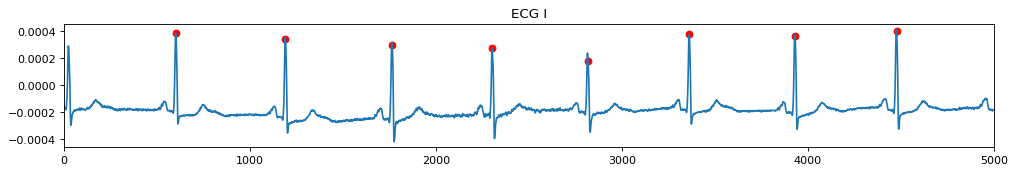

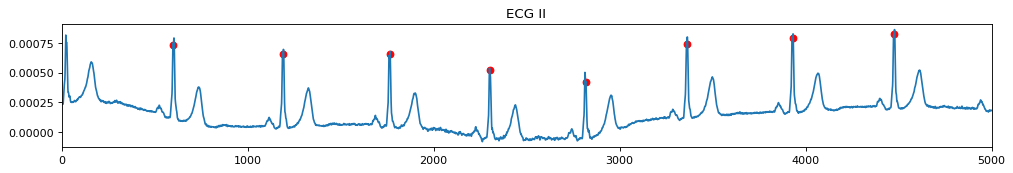

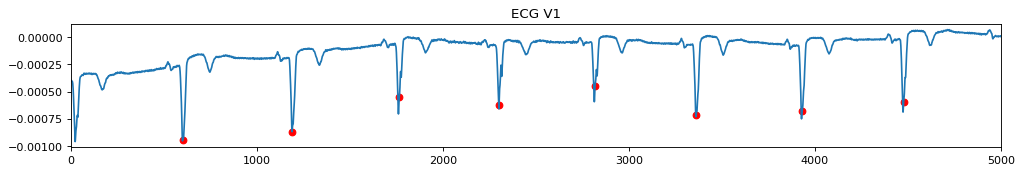

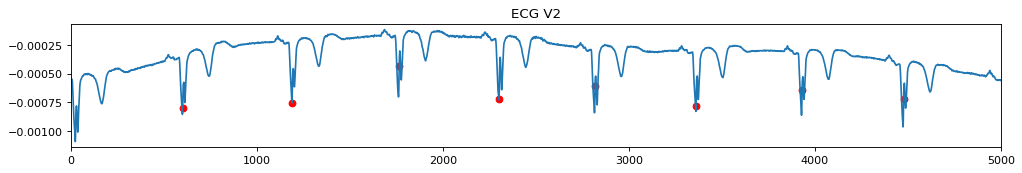

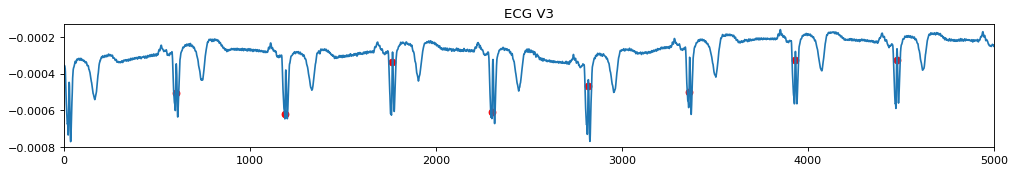

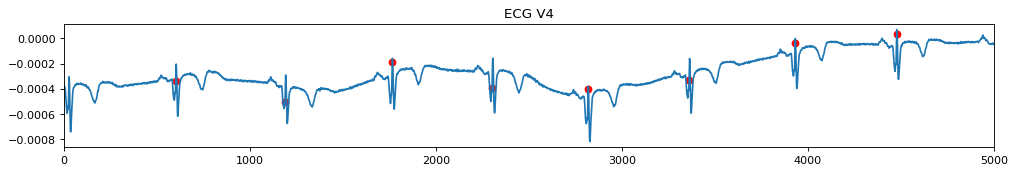

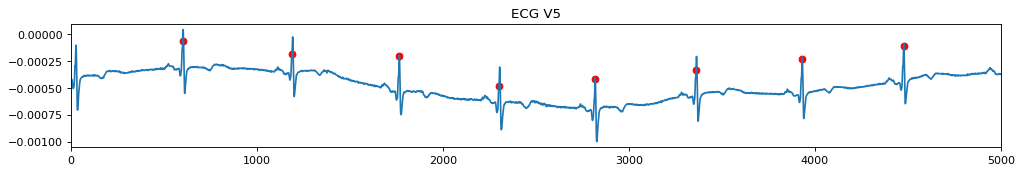

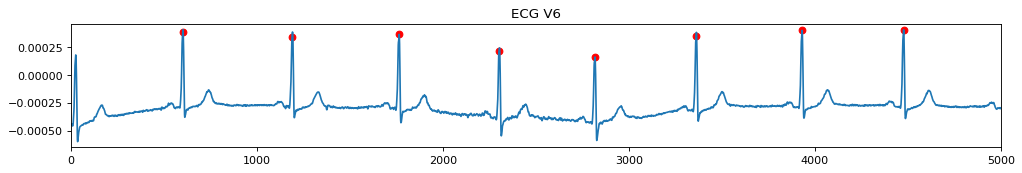

In [14]:
for graph in channels:
    sig = np.array(df[graph])
    figure(figsize=(15, 2), dpi=80)
    plt.plot(sig)
    plt.scatter(final_coord, sig[final_coord], color='red')
    plt.title(graph)
    plt.xlim([0, 5000]);

Можно еще попробовать реализовать фильтрацию ФВЧ чтобы убрать артефакты дыхания

Фильтр 3 порядка с f среза = 0.5 Гц

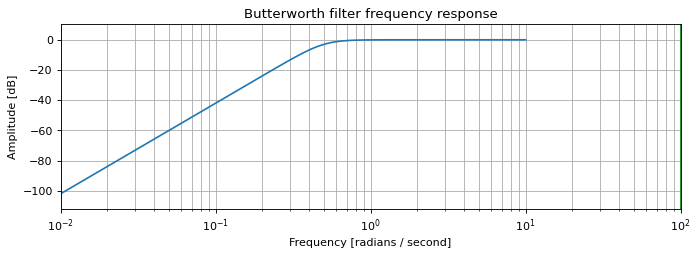

In [59]:
b, a = signal.butter(3, 0.5, 'hp', analog=True)
w, h = signal.freqs(b, a)
figure(figsize=(10, 3), dpi=80)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

Возьмем как пример сигнал со 2 отведения:

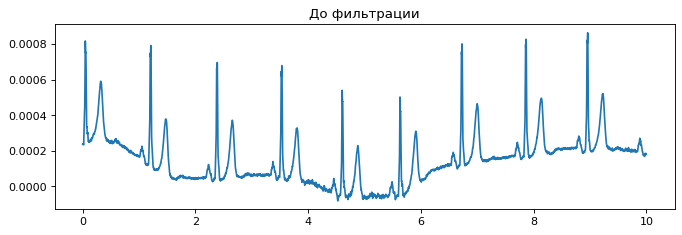

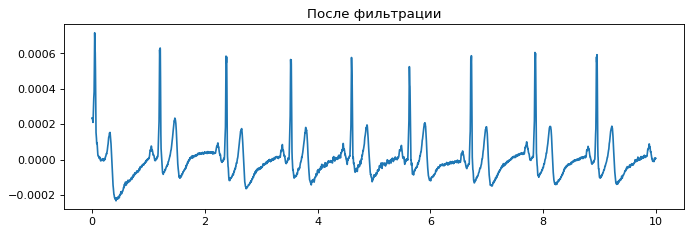

In [61]:
sig = np.array(df['ECG II'])
sos = signal.butter(3, 0.5, 'hp', fs=fd, output='sos')
filtered = signal.sosfilt(sos, sig)
figure(figsize=(10, 3), dpi=80)
plt.plot(t, sig)
plt.title('До фильтрации')
plt.show()
figure(figsize=(10, 3), dpi=80)
plt.plot(t, filtered)
plt.title('После фильтрации')
plt.show()

Так что можно перед нахождением вЭКГ заранее фильтром ФВЧ отфильтровать сигналы всех отведений. Данное действие реализуем опционально